# Đồ án 1 - Thu thập dữ liệu
# Crawl Data (parse HTML) 

Danh sách thành viên : 
- 18120229 Nguyễn Vinh Quang
- 18120208 Nguyễn Trần Nhật Minh
- 18120363 Đặng Văn Hiển
- 18120647 Lê Thanh Viễn
- 18120662 Trà Anh Toàn

** thời gian chạy khoảng 1 giờ đồng hồ với 1100 user (12p), 1007 track (15p), 1100 playlist (32p)

## Import

In [ ]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=ec73e80b6d602fc1c206d9cca5318de8881850bc40c9c22a33b6846492f02688
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [ ]:
import requests
import requests_cache
from bs4 import BeautifulSoup
import time
import json
import re
import pandas as pd # Dùng để đọc và hiển thị file csv/tsv
from datetime import datetime, timedelta # Dùng để xử lý dữ liệu thời gian
import os # Execute the command in a subshell
import re # Use regular expressions

import urllib.robotparser # Kiểm tra file robot.txt có được phép crawl không

## Explore website

In [ ]:
#Thử tìm file sitemap.xml trong file robots.txt
!python -m wget https://soundcloud.com/robots.txt


Saved under robots.txt


File robots.txt : <br>
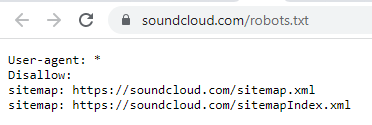


Ta có thể lấy được được danh sách url user :
  + RSS Feed (https://feeds.soundcloud.com/users/soundcloud:users:{user_id}/sounds.rss)
  + Parse XML (các https://sitemaps.sndcdn.com/sitemap-user-*.xml trong sitemapIndex.xml)
  + Crawl HTML (https://soundcloud.com/people/directory trong sitemap.xml)


In [ ]:
# Tải sitemapIndex.xml
!python -m wget https://soundcloud.com/sitemapIndex.xml


Saved under sitemapIndex.xml


## Configuration

In [ ]:
MAX_RECORDS = 1100
sleep_time = 1 # Đơn vị: giây

## Parse XML

#### Parse XML lấy danh sách user url

In [ ]:
sitemapIndexXML = "sitemapIndex.xml"
sitemapUserXMLs = []

user_urls = []
track_urls = []       
playlist_urls = []       

In [ ]:
# Parse sitemapIndex.xml to download sitemap-user-*.xml 
def Parse_SitemapIndexXML(sitemapIndexXML):

  #read sitemapIndex.xml 
  with open(sitemapIndexXML,'r') as f:
    content = f.read()

  # parse xml
  soup = BeautifulSoup(content,'xml')
  urls = soup.find_all('loc')

  # One sitemap-url have 50.000 user-urls 
  # About 34.700.000 users (=694*50.000) - nov/2/2021
  print(f"Number of urls is : {len(urls)}" )

  # We get only 1 sitemap-urls (360th/694)
  for i in range(360,361):
    sitemapUserXMLs.append(urls[i].text)
    print(urls[i].text)
  pass

In [ ]:
Parse_SitemapIndexXML(sitemapIndexXML)

Number of urls is : 694
https://sitemaps.sndcdn.com/sitemap-user-360-1636024320611.xml


In [ ]:
sitemapUserXMLs

['https://sitemaps.sndcdn.com/sitemap-user-360-1636024320611.xml']

In [ ]:
# Parse sitemapIndex.xml to download sitemap-user-*.xml 
def Parse_SitemapUserXML(sitemapUserXMLs):

  for i, sitemapUserXML in enumerate(sitemapUserXMLs):
    
    #read sitemap-user-*.xml   
    r = requests.get(sitemapUserXML)
    while(r.ok == False):
      time.sleep(sleep_time)
      r = requests.get(url)

    # parse xml
    soup = BeautifulSoup(r.content,'xml')
    urls = soup.find_all('loc')

    if len(user_urls)==0:
       print("Number of user-urls :")

    # We get only 5000 user-urls
    for index, url in enumerate(urls):
      user_urls.append(url.text)
      print("\r", end="")
      print('=>' + str(len(user_urls)), end="")
      if len(user_urls)>=5000 :
        break
      pass
    print("")
    pass

In [ ]:
%%time
Parse_SitemapUserXML(sitemapUserXMLs)

Number of user-urls :
=>5000
CPU times: user 8.23 s, sys: 531 ms, total: 8.77 s
Wall time: 9.59 s


## Parse HTML

### Crawl data lấy thông tin user

In [ ]:
def parseUsers(user_urls):              
  
  # Init column array
  user_ids = []
  usernames = []
  descriptions = []
  job_types = []
  permalink_urls = []
  station_permalinks = []
  uris = []
  citys = []
  country_codes = []
  avatar_urls = []
  visual_urls = []

  first_names = []
  last_names = []
  full_names = []

  created_ats = []
  last_modifieds = []

  creator_subscriptions = []
  verifieds = []

  followers_counts = []
  followings_counts = []
  groups_counts = []

  likes_counts = []
  comments_counts = []
  playlist_likes_counts = []

  track_counts = []
  playlist_counts = []
  reposts_counts = []
   
  # Crawl data
  for i, url in enumerate(user_urls):

    # Request to get page source
    r = requests.get(url)
    while(r.ok == False):
      time.sleep(sleep_time)
      r = requests.get(url)
    soup = BeautifulSoup(r.content, 'html.parser')
            
    # Define pattern to find script
    pattern = re.compile(r'(?<=\{"hydratable":"user","data":).*(?=\}\])', re.MULTILINE | re.DOTALL)
    script = soup.find("script", text=pattern)
    match = pattern.search(script.string)
    json_data = json.loads( match.group(0))

    user_id = json_data['id']
    username = json_data['username']
    description = json_data['description']
    job_type = soup.find("meta", property="og:type")['content']
    permalink_url = json_data['permalink_url']
    station_permalink = json_data['station_permalink']
    #uri = json_data['uri']
    city = json_data['city']
    country_code = json_data['country_code']
    avatar_url = json_data['avatar_url']
    visual_url = json_data['visuals']['visuals'][0]['visual_url']  if json_data['visuals'] else json_data['visuals']

    first_name = json_data['first_name']
    last_name = json_data['last_name']
    full_name = json_data['full_name']

    created_at = json_data['created_at']
    last_modified = json_data['last_modified']

    creator_subscription = json_data['creator_subscription']['product']['id']
    verified = json_data['verified']

    followers_count = json_data['followers_count']
    followings_count = json_data['followings_count']
    groups_count = json_data['groups_count']

    likes_count = json_data['likes_count']
    comments_count = json_data['comments_count']
    playlist_likes_count = json_data['playlist_likes_count']

    track_count = json_data['track_count']
    playlist_count = json_data['playlist_count']
    reposts_count = json_data['reposts_count']

    # Adding result to column array
    user_ids.append(user_id)
    usernames.append(username)
    descriptions.append(description)
    job_types.append(job_type)
    permalink_urls.append(permalink_url)
    station_permalinks.append(station_permalink)
    #uris.append(uri)
    citys.append(city)
    country_codes.append(country_code)
    avatar_urls.append(avatar_url)
    visual_urls.append(visual_url)

    first_names.append(first_name)
    last_names.append(last_name)
    full_names.append(full_name)

    created_ats.append(created_at)
    last_modifieds.append(last_modified)

    creator_subscriptions.append(creator_subscription)
    verifieds.append(verified)

    followers_counts.append(followers_count)
    followings_counts.append(followings_count)
    groups_counts.append(groups_count)

    likes_counts.append(likes_count)
    comments_counts.append(comments_count)
    playlist_likes_counts.append(playlist_likes_count)

    track_counts.append(track_count)
    playlist_counts.append(playlist_count)
    reposts_counts.append(reposts_count)

    print("\r", end="")
    print('=>' + str(i+1) + '/' + str(MAX_RECORDS), end="")
    if i+1>=MAX_RECORDS :
      break
    pass

  # Fill dataframe with column array
  data = {'user_id' : user_ids, 'username' : usernames, 'description' : descriptions, 'job_type' : job_types, 'permalink_url' :  permalink_urls, 'station_permalink' : station_permalinks, 'city' : citys, 'country_code' : country_codes, 'avatar_url' :  avatar_urls, 'visual_url' : visual_urls, 'first_name' : first_names, 'last_name' : last_names, 'full_name' : full_names, 'created_at' :  created_ats, 'last_modified' : last_modifieds, 'creator_subscription' : creator_subscriptions,  'verified' :  verifieds, 'followers_count' : followers_counts, 'followings_count' : followings_counts, 'groups_count' : groups_counts, 'likes_count' : likes_counts, 'comments_counts'  : comments_counts, 'playlist_likes_count' : playlist_likes_counts, 'track_count' : track_counts,  'playlist_count' : playlist_counts, 'reposts_count' : reposts_counts}
  users_df = pd.DataFrame(data)
  # Save dataframe to csv 
  users_df.to_csv('users.csv', index=False)
  print("")
  return users_df   

In [ ]:
%%time
users_df = parseUsers(user_urls) #About 12 minutes

=>1100/1100
CPU times: user 1min 6s, sys: 2.01 s, total: 1min 8s
Wall time: 12min 13s


In [ ]:
# View first 5 rows of users dataframe
users_df.head(10)

,user_id,username,description,job_type,permalink_url,station_permalink,city,country_code,avatar_url,visual_url,first_name,last_name,full_name,created_at,last_modified,creator_subscription,verified,followers_count,followings_count,groups_count,likes_count,comments_counts,playlist_likes_count,track_count,playlist_count,reposts_count
0,768877975,Merky! Events,140- DNB - BREAKS - BASSLINE\n\nUnderground ev...,music.musician,https://soundcloud.com/merky_events,artist-stations:768877975,Hull,GB,https://i1.sndcdn.com/avatars-000759546406-wi2...,https://i1.sndcdn.com/visuals-000768877975-5Ep...,,,,2020-01-21T00:31:26Z,2020-01-21T00:44:02Z,free,False,20,4,0,1,0,0,3,0,None
1,1197130,merkz,Twitter account @merkzmusic\n,music.musician,https://soundcloud.com/merkz-1,artist-stations:1197130,Birmingham,GB,https://i1.sndcdn.com/avatars-000214867428-2ml...,https://i1.sndcdn.com/visuals-000001197130-zpg...,,,,2010-06-18T12:41:31Z,2016-08-10T01:00:36Z,free,False,53,58,0,190,13,0,5,0,None
2,210328018,Merkz,"I'm Merk I play Guitar and sing,my band is cal...",music.musician,https://soundcloud.com/merkz-358448048,artist-stations:210328018,None,None,https://i1.sndcdn.com/avatars-000338930770-wdn...,https://i1.sndcdn.com/visuals-000210328018-Fpm...,Merk,,Merk,2016-03-05T23:23:04Z,2017-10-09T14:46:34Z,free,False,15,14,0,12,3,0,5,0,None
3,983395138,LEGION,Hi! I’m a very amateur music maker. I’m always...,music.musician,https://soundcloud.com/merkz-610724512,artist-stations:983395138,Pew Pew City,IN,https://i1.sndcdn.com/avatars-k5x0a9QW4DUIA78m...,None,MerkZ,MerkZ,MerkZ MerkZ,2021-05-10T12:48:37Z,2021-05-18T15:02:38Z,free,False,2,10,0,38,4,1,0,0,None
4,22203417,Merkz Artist,None,music.musician,https://soundcloud.com/merkz-artist,artist-stations:22203417,london,GB,https://i1.sndcdn.com/avatars-000020567968-y81...,None,Merdi,M1,Merdi M1,2012-08-15T14:49:22Z,2012-11-02T17:47:11Z,free,False,1,5,0,1,1,0,2,0,None
5,108555287,MerkZ M,None,music.musician,https://soundcloud.com/merkz-m,artist-stations:108555287,None,None,https://i1.sndcdn.com/avatars-000098845211-x04...,None,MerkZ,M,MerkZ M,2014-08-11T23:38:39Z,2014-08-11T23:38:40Z,free,False,2,14,0,0,0,0,1,0,None
6,142397750,MerkZ Mercado,None,music.musician,https://soundcloud.com/merkz-mercado,artist-stations:142397750,None,None,https://i1.sndcdn.com/avatars-000135047942-r95...,None,MerkZ,Mercado,MerkZ Mercado,2015-03-09T17:14:40Z,2015-03-09T17:14:41Z,free,False,5,0,0,0,0,0,1,2,None
7,284136548,MerkZ Mercado,None,music.musician,https://soundcloud.com/merkz-mercado-483064581,artist-stations:284136548,None,None,https://i1.sndcdn.com/avatars-000291668544-4ie...,None,MerkZ,Mercado,MerkZ Mercado,2017-01-23T03:16:45Z,2017-01-23T03:16:46Z,free,False,12,13,0,20,0,0,3,2,None
8,332500454,Merkz Merkz,None,music.musician,https://soundcloud.com/merkz-merkz,artist-stations:332500454,None,None,https://i1.sndcdn.com/avatars-000334976252-62u...,None,Merkz,Merkz,Merkz Merkz,2017-09-15T21:23:05Z,2017-09-15T21:23:06Z,free,False,2,0,0,3,0,0,1,0,None
9,796041187,Merkz,None,music.musician,https://soundcloud.com/merkz-music,artist-stations:796041187,None,None,https://a1.sndcdn.com/images/default_avatar_la...,None,,,,2020-03-19T11:32:34Z,2020-03-19T11:32:34Z,free,False,5,0,0,0,0,0,19,4,None


### Crawl data lấy thông tin track

In [ ]:
def parseTrack(user_urls):       

  track_urls = []       

  # Crawl user pages get track urls
  for i, url in enumerate(user_urls):
                
    # Request to get page source
    r = requests.get(url+'/tracks')
    while(r.ok == False):
      time.sleep(sleep_time)
      r = requests.get(url+'/tracks')
    soup = BeautifulSoup(r.content, 'html.parser')

    track_urls_2 = soup.find_all("article", class_="audible")
    if len(track_urls_2) == 0 :
      continue
    
    for track_url_2 in track_urls_2:
        track_url = track_url_2.find('a',{'itemprop':'url'})['href'] 
        track_urls.append(track_url)

    print("\r", end="")
    print('=>' + str(len(track_urls)) + '/' + str(MAX_RECORDS), end="")    

    if len(track_urls)>=MAX_RECORDS :
      break
    pass
  print("")


  # Init column array
  ids = []
  titles = []
  descriptions = []
  durations = []
  permalink_urls = []
  genres = []
  track_formats = []
  artwork_urls = []
  tag_lists = []

  user_ids = []
  station_permalinks = []
  album_titles = []

  waveform_urls = []
  hls_urls = []

  created_ats = []
  last_modifieds = []
  release_dates = []
  display_dates = []

  likes_counts = []
  download_counts = []
  comment_counts = []
  reposts_counts = []
  playback_counts = []

  # Crawl track urls
  for i, url in enumerate(track_urls):
                
    # Request to get page source
    r = requests.get('https://soundcloud.com'+url)
    while(r.ok == False):
      time.sleep(sleep_time)
      r = requests.get('https://soundcloud.com'+url)
    soup = BeautifulSoup(r.content, 'html.parser')

    # Define pattern to find script
    pattern = re.compile(r'(?<=\{"hydratable":"sound","data":).*(?=\}\])', re.MULTILINE | re.DOTALL)
    script = soup.find("script", text=pattern)
    match = pattern.search(script.string)
    json_data = json.loads( match.group(0))

    id = json_data['id']
    title = json_data['title']
    description = json_data['description']
    duration = json_data['duration']
    permalink_url = json_data['permalink_url']
    genre = json_data['genre']
    track_format = json_data['track_format']
    artwork_url = json_data['artwork_url']
    tag_list = json_data['tag_list']

    user_id = json_data['user_id']
    station_permalink = json_data['station_permalink']
    if json_data['publisher_metadata'] and 'album_title' in json_data['publisher_metadata']:
      album_title = json_data['publisher_metadata']['album_title'] 
    else :
      album_title = None

    if len(json_data['media']['transcodings']) > 0:
      hls_url = json_data['media']['transcodings'][0]['url']
    else :
      hls_url = None
    waveform_url = json_data['waveform_url']

    created_at = json_data['created_at']
    last_modified = json_data['last_modified']
    release_date = json_data['release_date']
    display_date = json_data['display_date']

    likes_count = json_data['likes_count']
    download_count = json_data['download_count']
    comment_count = json_data['comment_count']
    reposts_count = json_data['reposts_count']
    playback_count = json_data['playback_count']

    # Adding result to column array
    ids.append(id)
    titles.append(title)
    descriptions.append(description)
    durations.append(duration)
    permalink_urls.append(permalink_url)
    genres.append(genre)
    track_formats.append(track_format)
    artwork_urls.append(artwork_url)
    tag_lists.append(tag_list)

    user_ids.append(user_id)
    station_permalinks.append(station_permalink)
    album_titles.append(album_title)

    waveform_urls.append(waveform_url)
    hls_urls.append(hls_url)

    created_ats.append(created_at)
    last_modifieds.append(last_modified)
    release_dates.append(release_date)
    display_dates.append(display_date)

    likes_counts.append(likes_count)
    download_counts.append(download_count)
    comment_counts.append(comment_count)
    reposts_counts.append(reposts_count)
    playback_counts.append(playback_count)
    
    print("\r", end="")
    print('=>' + str(i+1) + '/' + str(len(track_urls)), end="")
    pass

  # Fill dataframe with column array
  data = {'id' : ids, 'title' : titles, 'description' : descriptions, 'duration' : durations, 'permalink_url' : permalink_urls, 'genre' : genres, 'track_format' : track_formats, 'artwork_url' : artwork_urls, 'tag_list' : tag_lists, 'user_id' : user_ids, 'station_permalink' : station_permalinks, 'album_title' : album_titles, 'waveform_url' : waveform_urls, 'hls_url' : hls_urls, 'created_at' : created_ats, 'last_modified' : last_modifieds, 'release_date' : release_dates, 'display_date' : display_dates, 'download_count' : download_counts, 'likes_count' : likes_counts, 'comment_count' : comment_counts, 'reposts_count' : reposts_counts, 'playback_count' : playback_counts}
  tracks_df = pd.DataFrame(data)
  # Save dataframe to csv 
  tracks_df.to_csv('tracks.csv', index=False)
  print("")
  return tracks_df

In [ ]:
%%time
tracks_df = parseTrack(user_urls) #About 15min

=>1107/1100
=>1107/1107
CPU times: user 53.3 s, sys: 2.26 s, total: 55.6 s
Wall time: 15min 10s


In [ ]:
# View first 5 rows of tracks dataframe
tracks_df.head(10)

,id,title,description,duration,permalink_url,genre,track_format,artwork_url,tag_list,user_id,station_permalink,album_title,waveform_url,hls_url,created_at,last_modified,release_date,display_date,download_count,likes_count,comment_count,reposts_count,playback_count
0,786911779,Merky! Guest Mix Vol. 2 - Calm Stiege,We continue our guest series with ex Crystal C...,1436186,https://soundcloud.com/merky_events/merky-gues...,Garage,single-track,https://i1.sndcdn.com/artworks-qA1625dzEYGveo6...,XDJ-RX2 Grime ukf Uk Funky 140 Garage,768877975,track-stations:786911779,None,https://wave.sndcdn.com/gkrVH4fzpWYZ_m.json,https://api-v2.soundcloud.com/media/soundcloud...,2020-03-30T16:28:09Z,2020-03-30T16:28:11Z,None,2020-03-30T16:28:09Z,0,5,0,4,75
1,778444612,Merky! Guest Mix Vol. 1 - Collate,Kicking off our guest mix series with local DJ...,1285068,https://soundcloud.com/merky_events/merky-gues...,Drum & Bass,single-track,https://i1.sndcdn.com/artworks-tz0e1g24d3AVfkN...,"dnb liquid Mix rollers Jungle ""jump up"" ""Drum ...",768877975,track-stations:778444612,None,https://wave.sndcdn.com/r4jLDhL2iegJ_m.json,https://api-v2.soundcloud.com/media/soundcloud...,2020-03-18T18:31:24Z,2020-03-18T18:33:02Z,None,2020-03-18T18:31:24Z,0,8,0,5,90
2,749818084,"Chillo - VOL. 1, Jan 2020",A mix of DnB from our Co-Owner and resident DJ...,2019709,https://soundcloud.com/merky_events/chillo-vol...,Drum & Bass,single-track,https://i1.sndcdn.com/artworks-000674634901-9u...,Dnb Drums bass jumpup rollers jungle electrontic,768877975,track-stations:749818084,None,https://wave.sndcdn.com/9gbqzKQbXtqk_m.json,https://api-v2.soundcloud.com/media/soundcloud...,2020-01-26T16:26:53Z,2020-01-26T16:26:56Z,None,2020-01-26T16:26:53Z,0,16,2,6,182
3,37584396,Selected Thoughts,brand new hip hop freestyle hope u enjoy\r\nry...,324223,https://soundcloud.com/merkz-1/selected-thoughts,Hiphop,single-track,None,,1197130,track-stations:37584396,None,https://wave.sndcdn.com/lQMbBYpWl1r5_m.json,https://api-v2.soundcloud.com/media/soundcloud...,2012-02-23T16:18:56Z,2017-01-08T17:43:58Z,None,2012-02-23T16:18:56Z,0,2,0,1,155
4,37583982,Bars and Lyrics,brand new grime tune ona ryt-t production 2012...,157996,https://soundcloud.com/merkz-1/bars-and-lyrics,Grime,single-track,None,,1197130,track-stations:37583982,None,https://wave.sndcdn.com/nXFEYjnTt1ek_m.json,https://api-v2.soundcloud.com/media/soundcloud...,2012-02-23T16:13:55Z,2016-02-04T14:39:14Z,None,2012-02-23T16:13:55Z,17,4,0,1,277
5,3517954,Merkz Clee Dot Repta - SprayOut,,192857,https://soundcloud.com/merkz-1/merkz-clee-dot-...,Grime,single-track,None,,1197130,track-stations:3517954,None,https://wave.sndcdn.com/KvpDwZwpGVn1_m.json,https://api-v2.soundcloud.com/media/soundcloud...,2010-06-18T13:21:43Z,2011-06-22T18:12:36Z,None,2010-06-18T13:21:43Z,0,2,1,0,348
6,3517848,Merkz - Drunken NarStyle,merkz drunken nar style \r\nfreestyle \r\n,175033,https://soundcloud.com/merkz-1/merkz-drunken-n...,Grime,single-track,None,grime merkz nar narentertainment ukgrimescene ...,1197130,track-stations:3517848,None,https://wave.sndcdn.com/L0zeFiX5JtDt_m.json,https://api-v2.soundcloud.com/media/soundcloud...,2010-06-18T13:12:12Z,2011-05-14T19:29:04Z,None,2010-06-18T13:12:12Z,0,4,4,2,324
7,3517671,Merkz & Capeash - Rally,merkz n capeash - rally -\r\nkaper studios,200775,https://soundcloud.com/merkz-1/merkz-capeash-r...,Grime,single-track,None,,1197130,track-stations:3517671,None,https://wave.sndcdn.com/Ei1zo30LnjQm_m.json,https://api-v2.soundcloud.com/media/soundcloud...,2010-06-18T12:54:14Z,2010-06-18T12:56:27Z,None,2010-06-18T12:54:14Z,0,2,1,0,323
8,250671838,Come As You Are Cover with Marco Canali,,170046,https://soundcloud.com/merkz-358448048/come-as...,,single-track,https://i1.sndcdn.com/artworks-000149999253-4h...,,210328018,track-stations:250671838,None,https://wave.sndcdn.com/pXc3A6Ek8bKt_m.json,https://api-v2.soundcloud.com/media/soundcloud...,2016-03-07T16:29:16Z,2016-03-07T16:44:51Z,None,2016-03-07T16:29:16Z,0,2,0,1,132
9,250671836,Dammit C

### Crawl data lấy thông tin playlist

In [ ]:
def parsePlaylist(user_urls):       

  playlist_urls = []       

  # Crawl user pages get track urls
  for i, url in enumerate(user_urls):
                
    # Request to get page source
    r = requests.get(url+'/sets')
    while(r.ok == False):
      time.sleep(sleep_time)
      r = requests.get(url+'/sets')
    soup = BeautifulSoup(r.content, 'html.parser')

    playlist_urls_2 = soup.find_all("article", class_="audible")
    
    if len(playlist_urls_2) == 0 :
      continue
    
    for playlist_url_2 in playlist_urls_2:
        playlist_url = playlist_url_2.find('a',{'itemprop':'url'})['href'] 
        playlist_urls.append(playlist_url)

    print("\r", end="")
    print('=>' + str(len(playlist_urls)) + '/' + str(MAX_RECORDS), end="")
    
    if len(playlist_urls)>=MAX_RECORDS :
      break
    pass
  print("")


  # Init column array
  ids = []
  titles = []
  descriptions = []
  durations = []
  permalink_urls = []
  genres = []
  track_formats = []
  artwork_urls = []
  tag_lists = []

  user_ids = []

  created_ats = []
  last_modifieds = []
  release_dates = []
  display_dates = []

  track_counts = []
  likes_counts = []
  reposts_counts = []

  tracks = []
  # Crawl track urls
  for i, url in enumerate(playlist_urls):
                
    # Request to get page source
    r = requests.get('https://soundcloud.com'+url)
    while(r.ok == False):
      time.sleep(sleep_time)
      r = requests.get('https://soundcloud.com'+url)
    soup = BeautifulSoup(r.content, 'html.parser')

    # Define pattern to find script
    pattern = re.compile(r'(?<=\{"hydratable":"playlist","data":).*(?=\}\])', re.MULTILINE | re.DOTALL)
    script = soup.find("script", text=pattern)
    match = pattern.search(script.string)
    json_data = json.loads( match.group(0))

    id = json_data['id']
    title = json_data['title']
    description = json_data['description']
    duration = json_data['duration']
    permalink_url = json_data['permalink_url']
    genre = json_data['genre']
    artwork_url = json_data['artwork_url']
    tag_list = json_data['tag_list']

    user_id = json_data['user_id']

    created_at = json_data['created_at']
    last_modified = json_data['last_modified']
    release_date = json_data['release_date']
    display_date = json_data['display_date']

    track_count = json_data['track_count']
    likes_count = json_data['likes_count']
    reposts_count = json_data['reposts_count']

    tracks_arr = json_data['tracks']
    track = ""
    for tracks_i in tracks_arr:
      track += (str(tracks_i['id'])+', ')

    pass

    # Adding result to column array
    ids.append(id)
    titles.append(title)
    descriptions.append(description)
    durations.append(duration)
    permalink_urls.append(permalink_url)
    genres.append(genre)
    artwork_urls.append(artwork_url)
    tag_lists.append(tag_list)

    user_ids.append(user_id)

    created_ats.append(created_at)
    last_modifieds.append(last_modified)
    release_dates.append(release_date)
    display_dates.append(display_date)

    tracks.append(track)
    track_counts.append(track_count)
    likes_counts.append(likes_count)
    reposts_counts.append(reposts_count)

    print("\r", end="")
    print('=>' + str(i+1) + '/' + str(len(playlist_urls)), end="")
    pass

  # Fill dataframe with column array
  data = {'id' : ids, 'title' : titles, 'description' : descriptions, 'duration' : durations, 'permalink_url' : permalink_urls, 'genre' : genres, 'artwork_url' : artwork_urls, 'tag_list' : tag_lists, 'user_id' : user_ids, 'created_at' : created_ats, 'last_modified' : last_modifieds, 'release_date' : release_dates, 'display_date' : display_dates, 'tracks' : tracks, 'track_count' : track_counts, 'likes_count' : likes_counts, 'reposts_count' : reposts_counts}
  playlists_df = pd.DataFrame(data)
  # Save dataframe to csv 
  playlists_df.to_csv('playlists.csv', index=False)
  print("")
  return playlists_df   

In [ ]:
%%time
playlists_df = parsePlaylist(user_urls) # About 32min

=>1100/1100
=>1100/1100
CPU times: user 2min 24s, sys: 4.32 s, total: 2min 28s
Wall time: 32min 34s


In [ ]:
# View first 5 rows of playlists dataframe
playlists_df.head(10)

,id,title,description,duration,permalink_url,genre,artwork_url,tag_list,user_id,created_at,last_modified,release_date,display_date,tracks,track_count,likes_count,reposts_count
0,88273524,Music,None,1895590,https://soundcloud.com/merkz-mercado/sets/music,,None,,142397750,2015-03-11T04:02:21Z,2015-03-11T04:02:21Z,None,2015-03-11T04:02:21Z,"44168362, 97656500,",2,0,0
1,87994031,Merkz Beats,None,0,https://soundcloud.com/merkz-mercado/sets/merk...,,None,,142397750,2015-03-10T05:55:45Z,2015-03-10T05:55:45Z,None,2015-03-10T05:55:45Z,,0,0,0
2,356937925,New Music🎶,None,3539963,https://soundcloud.com/merkz-mercado-483064581...,,None,,284136548,2017-10-02T10:23:14Z,2017-10-02T10:23:14Z,None,2017-10-02T10:23:14Z,"344529390, 315549497, 307984539, 343430075, 19...",16,0,0
3,335734497,MerkZ 719,None,8802142,https://soundcloud.com/merkz-mercado-483064581...,,None,,284136548,2017-07-06T04:34:28Z,2017-07-06T04:34:28Z,None,2017-07-06T04:34:28Z,"309689093, 321622679, 263980205, 290136983, 29...",41,1,0
4,93243423,merkin em,None,1290171,https://soundcloud.com/merkz44th/sets/merkin-em,,None,,145257193,2015-03-27T20:16:10Z,2015-03-27T20:16:11Z,None,2015-03-27T20:16:10Z,"194471328, 187105448, 102381741, 134903313,",4,1,0
5,666329262,Rough,None,323843,https://soundcloud.com/merkzilla/sets/rough,,None,,26464421,2018-12-18T01:31:30Z,2018-12-18T01:36:11Z,None,2018-12-18T01:31:30Z,"396615804, 309721082,",2,0,0
6,666327276,Smooth,None,284986,https://soundcloud.com/merkzilla/sets/smooth,,None,,26464421,2018-12-18T01:27:27Z,2018-12-18T01:29:23Z,None,2018-12-18T01:27:27Z,"421406832, 493055367,",2,0,0
7,715555620,Still Searching,#SS18,911388,https://soundcloud.com/merkzofficial/sets/stil...,Hip-hop & Rap,https://i1.sndcdn.com/artworks-000493712211-xf...,,59635510,2019-02-23T18:56:45Z,2019-02-25T08:53:46Z,2018-09-17T00:00:00Z,2019-02-25T08:53:46Z,"580138563, 580138560, 580138548, 580138539, 58...",5,13,9
8,655352994,Broken Pieces,None,828103,https://soundcloud.com/merkzrns/sets/broken-pi...,Hip Hop,None,Rap Trap Dancehall Mixtape,2561250,2018-12-01T19:10:23Z,2019-12-07T02:44:57Z,None,2018-12-01T19:10:23Z,"538309557, 538312119, 293659589, 485972028,",4,3,0
9,723737016,☁️,None,14029983,https://soundcloud.com/merkzyyy/sets/lq6j0vtleldr,,https://i1.sndcdn.com/artworks-000522447495-wt...,,147574098,2019-03-06T22:43:52Z,2020-10-22T03:22:26Z,None,2019-03-06T22:51:55Z,"329069406, 494949213, 419842804, 499700643, 46...",70,2,0


Ý nghĩa các đặc trưng của bảng user :
*  user_id : mã user
*  username	: tên định danh 
*  description : dòng tự miêu tả 
*  job_type	: loại nghề nhgiệp 
*  permalink_url : đường dẫn trang cá nhân trân soundcloud
*  station_permalink : đường dẫn station 
*  city : thành phố 
*  country_code	: mã quốc gia
*  avatar_url	: đường dẫn hình đại diện
*  visual_url	: đường dẫn hình nền
*  first_name	: tên
*  last_name : họ
*  full_name : 
*  created_at	: ngày tạo
*  last_modified : ngày cập nhật gần nhất
*  creator_subscription : loại tài khoản
*  verified	: xác thực tài khoản nghệ sĩ
*  followers_count : số người theo dõi
*  followings_count	: số người user đang theo dõi
*  groups_count	: số group tham gia
*  likes_count : số like nhận được
*  comments_counts : số comment nhận được
*  playlist_likes_count : số like nhận được cho playlist 
*  track_count : số track
*  playlist_count : số playlist
*  reposts_count : số repost

Ý nghĩa các đặc trưng của bảng track :
* id : mã track
* title  : tiêu đề 
* description  : dòng miêu tả 
* duration : thời lượng 
* permalink_url : đường dẫn trang track
* genre : thể loại
* track_format  : định dạng
* artwork_url  : đường dẫn hình track
* tag_list  : danh sách các tag
* user_id  :  mã user sở hữu track
* station_permalink  : đường dẫn station
* album_title  : tiêu đề album
* waveform_url  : đường dẫn file waveform
* hls_url  : đường dẫn stream hls
* created_at  : ngày tạo
* last_modified  : ngày cập nhật gần nhất
* release_date  : ngày xuất bản
* display_date  : ngày hiển thị
* download_count  : số lượt tải về
* likes_count  : số like nhận được
* comment_count  : số bình luận nhận được
* reposts_count  : số lượt repost
* playback_count : số lần phát lại

Ý nghĩa các đặc trưng của bảng playlist :
* id : mã playlist
* title : tiêu đề 
* description : dòng miêu tả 
* duration : tổng thời lượng các track
* permalink_url : đường dẫn trang playlist
* genre : thể loại
* artwork_url : đường dẫn hình playlist
* tag_list : danh sách các tag
* user_id : mã user sở hữu playlist
* created_at : ngày tạo
* last_modified : ngày cập nhật gần nhất
* release_date : ngày xuất bản
* display_date : ngày hiển thị
* tracks : danh sách các track (chuỗi đc tách nhau bởi dấu ',')
* track_count : số track trong playlist
* likes_count : số like nhận được
* reposts_count: số lượt repost
